# Skin Cancer Detection
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

  More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.








![](http://www.justscience.in/wp-content/uploads/2017/12/what-causes-skin-cancer.jpg)

## Imports

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from glob import glob
from PIL import Image
from sklearn.utils import shuffle

In [0]:
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [80]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print('Tensorflow version: ',tf.__version__)
print('Is GPU available: %s' % str(tf.test.is_gpu_available()))
print('Is Eager Execution enabled?: %s' % str(tf.executing_eagerly()))

Tensorflow version:  1.15.0
Is GPU available: True
Is Eager Execution enabled?: False


## Dataset
#### About HAM10000
In this exercise will will be using HAM10000 ("Human Against Machine with 10000 training images") dataset which is a collection of "dermatoscopic images from different populations, acquired and stored by different modalities."Kaggle This dataset has ~10K dermatoscopic images that have been reformatted to be similar smaller like the famous Handwritten Digit or MNIST dataset (64 x 64 images centered on the subject). This allows us to focus on setting up our environment and making sure we can get a model working on a more interesting, healthcare-related problem.

In [8]:
!pip install kaggle
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"joey1004","key":"3a7926f8f05b07f460a5c7ecc3c26c19"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [10]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [11]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list -s cancer

ref                                                   title                                           size  lastUpdated          downloadCount  
----------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
xiaotawkaggle/inhibitors                              Cancer Inhibitors                              104MB  2019-11-14 06:48:37           2879  
kmader/skin-cancer-mnist-ham10000                     Skin Cancer MNIST: HAM10000                      5GB  2018-09-20 20:36:13          18811  
piotrgrabo/breastcancerproteomes                      Breast Cancer Proteomes                          5MB  2019-11-14 05:15:12           7489  
loveall/cervical-cancer-risk-classification           Cervical Cancer Risk Classification              9KB  2017-08-31 01:02:22          10898  
uciml/breast-cancer-wisconsin-data                    Breast Cancer Wisconsin (Diagnostic) Data Set   49KB  2016-09-25 10:49:04   

In [12]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p data/

100% 5.19G/5.20G [01:41<00:00, 41.5MB/s]
100% 5.20G/5.20G [01:41<00:00, 55.0MB/s]


In [13]:
!unzip data/skin-cancer-mnist-ham10000.zip -d data/

Archive:  data/skin-cancer-mnist-ham10000.zip
  inflating: data/HAM10000_images_part_1/ISIC_0024306.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024307.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024308.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024309.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024310.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024311.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024312.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024313.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024314.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024315.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024316.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024317.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024318.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024319.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024320.jpg  
  inflating: data/HAM10000_images_part_1/ISIC_0024321.

#Setup and data preparation

In [0]:
base_skin_dir = os.path.join('data')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [27]:
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Create some new columns (path to image, human-readable name) and review them

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['lesion_type'] = df['dx'].map(lesion_type_dict.get) 
df['lesion_type_idx'] = pd.Categorical(df['lesion_type']).codes
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,lesion_type,lesion_type_idx
5185,HAM_0006308,ISIC_0030716,nv,follow_up,55.0,female,lower extremity,data/ham10000_images_part_2/ISIC_0030716.jpg,Melanocytic nevi,4
5489,HAM_0001201,ISIC_0024691,nv,follow_up,50.0,female,trunk,data/ham10000_images_part_1/ISIC_0024691.jpg,Melanocytic nevi,4
6813,HAM_0001342,ISIC_0032378,nv,histo,55.0,female,abdomen,data/ham10000_images_part_2/ISIC_0032378.jpg,Melanocytic nevi,4
481,HAM_0003840,ISIC_0027801,bkl,histo,55.0,female,face,data/ham10000_images_part_1/ISIC_0027801.jpg,Benign keratosis,2
6148,HAM_0002041,ISIC_0028532,nv,follow_up,35.0,male,abdomen,data/ham10000_images_part_1/ISIC_0028532.jpg,Melanocytic nevi,4


In [28]:
print(df.lesion_type.value_counts())

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion_type, dtype: int64


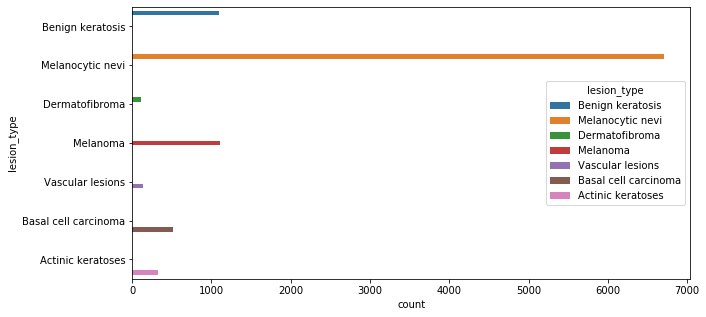

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(y='lesion_type', data=df, hue='lesion_type', ax= ax1)

### Data Cleaning

In [32]:
df.isnull().sum()

lesion_id           0
image_id            0
dx                  0
dx_type             0
age                57
sex                 0
localization        0
path                0
lesion_type         0
lesion_type_idx     0
dtype: int64

In [0]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [34]:
df.isnull().sum()

lesion_id          0
image_id           0
dx                 0
dx_type            0
age                0
sex                0
localization       0
path               0
lesion_type        0
lesion_type_idx    0
dtype: int64

### Oversampling and Undersampling 

In [0]:
num_sample = 800

df_df = (df.loc[df['dx']=='df']).sample(num_sample, replace = True)
df_vasc = (df.loc[df['dx']=='vasc']).sample(num_sample, replace = True)
df_akiec = (df.loc[df['dx'] == "akiec"]).sample(num_sample,replace = True)
df_bcc = df.loc[df['dx'] == "bcc"][0:num_sample].sample(num_sample,replace = True)
df_bkl = df.loc[df['dx'] == "bkl"][0:num_sample].sample(num_sample) 
df_mel = df.loc[df['dx'] == "mel"][0:num_sample].sample(num_sample)
df_nv = df.loc[df['dx'] == "nv"][0:num_sample].sample(num_sample)

skin_df = pd.concat([df_akiec, df_bcc, df_bkl, df_df, df_mel, df_nv, df_vasc])
skin_df = shuffle(skin_df)

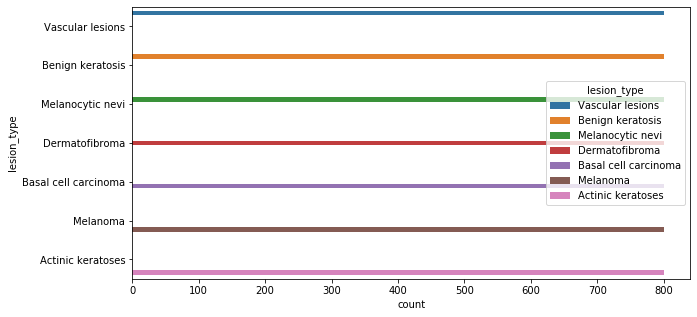

In [40]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y = 'lesion_type', data = skin_df, hue='lesion_type', ax = ax1)

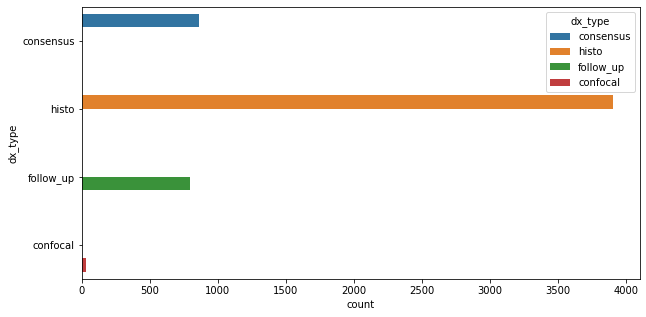

In [45]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y = 'dx_type', data = skin_df, hue='dx_type', ax = ax1)

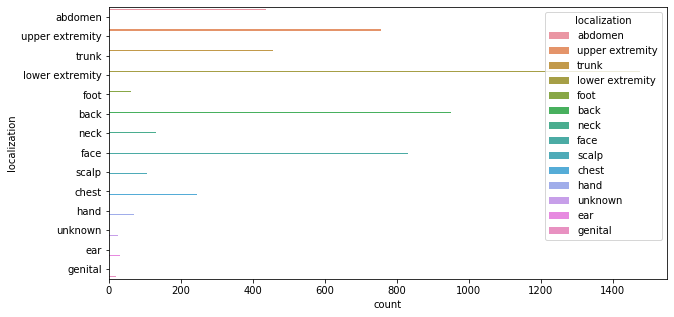

In [46]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y = 'localization', data = skin_df, hue='localization', ax = ax1)

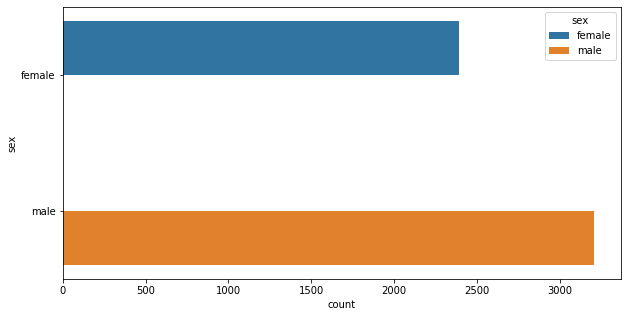

In [47]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y = 'sex', data = skin_df, hue='sex', ax = ax1)

###Import and resize images

In [0]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

In [0]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    5600
Name: image, dtype: int64

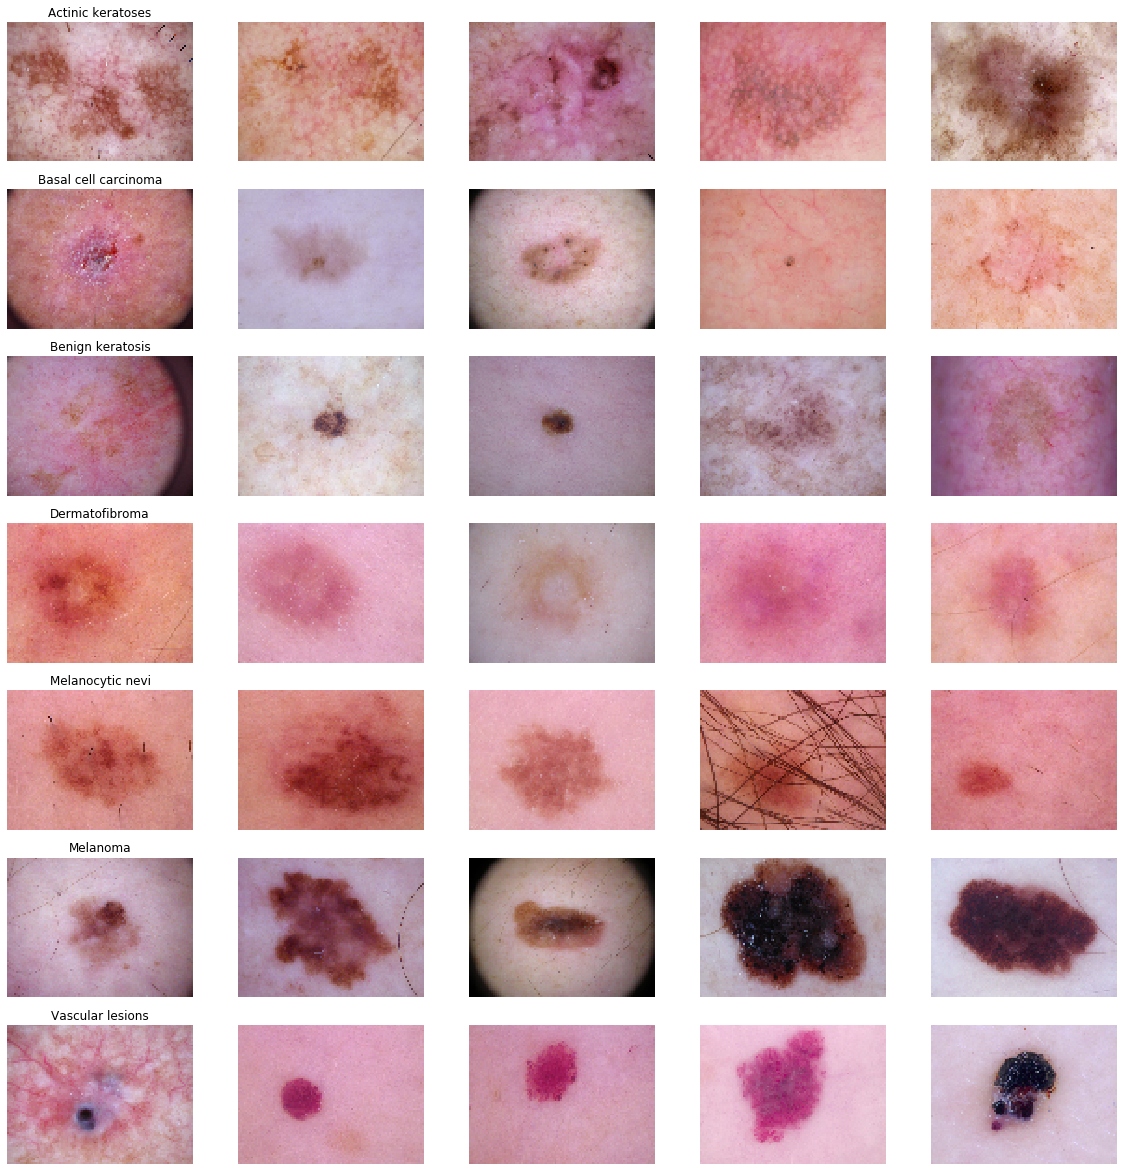

In [51]:
n_cols = 5
fig, m_axs = plt.subplots(7, n_cols, figsize = (4 * n_cols, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['lesion_type']).groupby('lesion_type')):
  n_axs[0].set_title(type_name)
  for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_cols, random_state=2019).iterrows()):
    c_ax.imshow(c_row['image'])
    c_ax.axis('off')
fig.savefig('categorical_samples.png', dpi = 300)

### Color channel analysis
  How do the narmalized color samples vary across different types of skin diseases?

In [53]:
rgb_info_df = skin_df.apply(lambda x: pd.Series({
    '{}_mean'.format(k): v for k, v in zip(['Red', 'Green', 'Blue'], np.mean(x['image'],(0, 1)))
}), 1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
  rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(10)

,Red_mean,Green_mean,Blue_mean,Gray_mean
421,0.986767,0.924627,1.088605,143.602489
9994,1.277340,0.879753,0.842907,152.391067
9972,1.116881,0.903481,0.979638,173.535244
2662,1.019836,0.968000,1.012164,178.401956
2391,1.150088,0.853538,0.996374,141.603600
1415,1.182715,0.885871,0.931413,140.620267
1497,1.057360,0.879042,1.063598,164.399956
334,1.260339,0.899923,0.839738,150.474311
2421,1.176980,0.843044,0.979976,163.818622
90,1.140536,0.862521,0.996943,119.214089


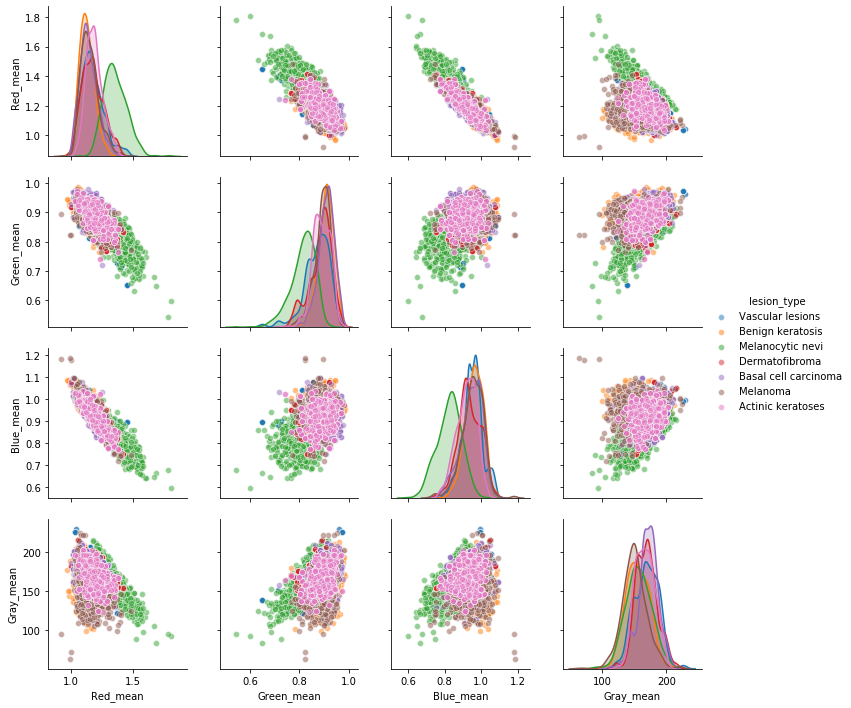

In [55]:
for c_col in rgb_info_df.columns:
  skin_df[c_col] = rgb_info_df[c_col].values

sns.pairplot(skin_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'lesion_type']],
             hue = 'lesion_type', plot_kws = {'alpha': 0.5})

The plot above showed that, Melanocytic nevi always appears an obvious rgb distribution. 

### Train Test Split

In [0]:
features=skin_df.drop(columns=['lesion_type_idx'],axis=1)
target=skin_df['lesion_type_idx']

from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=1234)

### Normalization and Label Encoding
Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these labels to one hot vectors.

In [0]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

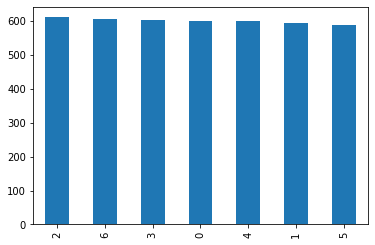

In [70]:
y_train_o.value_counts().plot(kind='bar')

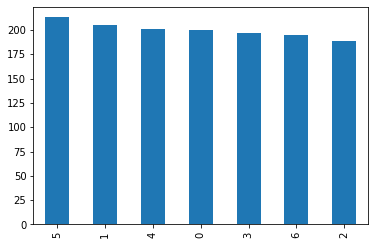

In [71]:
y_test_o.value_counts().plot(kind='bar')

### Splitting training and validation split
I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

In [0]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2019)

In [0]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

### Model Building


In [84]:
input_shape = (75, 100, 3) 
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 73, 98, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 71, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 48, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 48, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 107520)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               13762688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

In [0]:
model.compile(optimizer = 'adam',loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [105]:
batch_size = 15
epochs = 30

history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0],
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0],
    callbacks=[learning_rate_reduction]
)


Epoch 1/30
3780/3780 [==============================] - 120s 32ms/step - loss: 1.4179 - acc: 0.6056 - val_loss: 0.5417 - val_acc: 0.8262
Epoch 2/30
3780/3780 [==============================] - 119s 31ms/step - loss: 1.0561 - acc: 0.6282 - val_loss: 0.5287 - val_acc: 0.8167
Epoch 3/30
3780/3780 [==============================] - 119s 32ms/step - loss: 0.9474 - acc: 0.6577 - val_loss: 0.5215 - val_acc: 0.8381
Epoch 4/30
3780/3780 [==============================] - 120s 32ms/step - loss: 0.8710 - acc: 0.6793 - val_loss: 0.4849 - val_acc: 0.8476
Epoch 5/30
3780/3780 [==============================] - 120s 32ms/step - loss: 0.8110 - acc: 0.7017 - val_loss: 0.4819 - val_acc: 0.8548
Epoch 6/30
3780/3780 [==============================] - 121s 32ms/step - loss: 0.7597 - acc: 0.7198 - val_loss: 0.4815 - val_acc: 0.8571
Epoch 7/30
3780/3780 [==============================] - 121s 32ms/step - loss: 0.7148 - acc: 0.7347 - val_loss: 0.4804 - val_acc: 0.8524
Epoch 8/30
3780/3780 [===================

### Model Evaluation

In [106]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

420/420 [==============================] - 0s 283us/step
Validation: accuracy = 0.866667  ;  loss_v = 0.557118
Test: accuracy = 0.888571  ;  loss = 0.421883


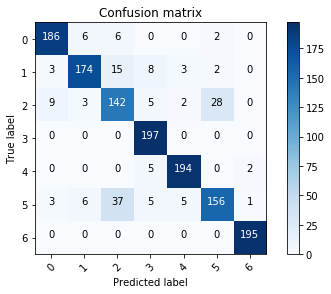

In [110]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

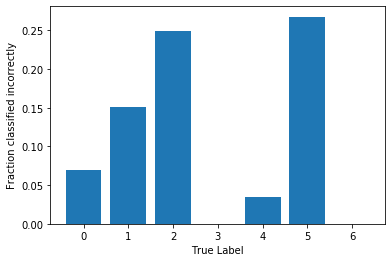

In [121]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

### Conclusion
As plot above illustrated,our model has maximum number of incorrect predictions for Vascular lesions which has code 5, then second most missclassified type is Benign Ceratosis code 2 then Melanoma code 1 where as Basal cell carcinoma code 3 and Dermatofibroma code 6 has least misclassified type.

We can also further tune our model to easily achieve the accuracy above 88.85% and I think still this model is efficient in comparison to detection with human eyes having 77.0344% accuracy
